In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
import matplotlib.ticker as ticker
import pandas as pd
import glob
import re

# Statistics
import scipy.integrate as integrate
from scipy.stats import norm
from scipy.special import factorial
from scipy.special import gammaln
import scipy.optimize as spo
import emcee
import corner

# Parallel
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

In [2]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [3]:
#data = pd.read_csv('Data/NData_NBkg_Signal112.csv',sep=',')
data = pd.read_csv('Data/1Channel.csv',sep=',')
labels = list(data.keys())
n = np.array(data[labels[0]])
b = np.array(data[labels[1]])
s = np.array(data[labels[2]])
N = n.shape[0]

In [4]:
# Log Prior
def LogPrior(p):

    mu,e = p 

    if np.isscalar(mu) and np.isscalar(e):
        if mu > 0. and e > 0.:
            return 0.
        else:
            return -np.inf
    else:
        if np.all( mu > 0 ) and np.all( e > 0. ):
            return 0.
        else:
            return -np.inf

In [5]:
# Efficiency distribution
def Gauss(x,mean=1.,sigma=0.1):
    return norm.pdf(x,loc=mean,scale=sigma)

In [7]:
# Likelihood function
def LogLikelihood(p,n,b,s):

    # Distribution parameters
    mu,e = p
    
    # Regularizador 
    r = 1e-5
    lambda_ = mu*s + e*b + r 
    
    log_likelihood = -lambda_ + n * np.log( lambda_ ) - gammaln( n+1 )     
        
    return log_likelihood

In [135]:
def GetJointLogLikelihood(p,n,b,s):
    
    mu,e = p
    
    JointLike = 0.
    
    for c in range(N):
        
        # Each cannel has its own uncertainty
        #sigmab = b[c]/np.sqrt(b[c])
        sigmab = 0.25
        
        JointLike += LogLikelihood( p, n[c], b[c], s[c] )
        JointLike += np.log( Gauss(e, 1., sigmab) ) # The efficieny has a mean of 1

    return JointLike

In [136]:
def LogPosterior(p,n,b,s):
    return GetJointLogLikelihood(p,n,b,s) + LogPrior(p)

In [137]:
LogPosterior(np.array([0.1,0.1]),n,b,s)

-152.1461041969713

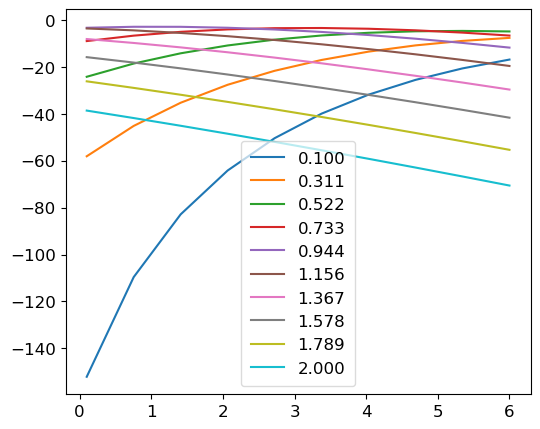

In [138]:
mu = np.linspace(0.1,6.,10)
epsilon = np.linspace(0.1,2.,10)

for e in range(len(epsilon)):

    Posterior = np.zeros_like(mu)
    
    for j in range(len(mu)):
        Posterior[j] = LogPosterior(np.array([mu[j],epsilon[e]]),n,b,s)
    
    plt.plot(mu,Posterior,label='%.3f'%(epsilon[e]))
    
plt.legend()

# Algoritmo de metropolis

In [139]:
nll = lambda *p: LogPosterior(*p)
# Testing the posterior
pt = np.array([1.,1.])
nll(pt,n,b,s)

-2.8947553416444642

In [140]:
# Algoritmo de metropolis
n_walkers, n_params = 6,2
p0 = np.zeros((n_walkers,n_params))
p0[:,0] = 10.
p0 += np.random.rand(n_walkers,n_params)

In [141]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, nll, args=(n,b,s), a=0.01)
pos,prob,state = sampler.run_mcmc(p0, 10000, progress = True)

100%|█████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1070.48it/s]


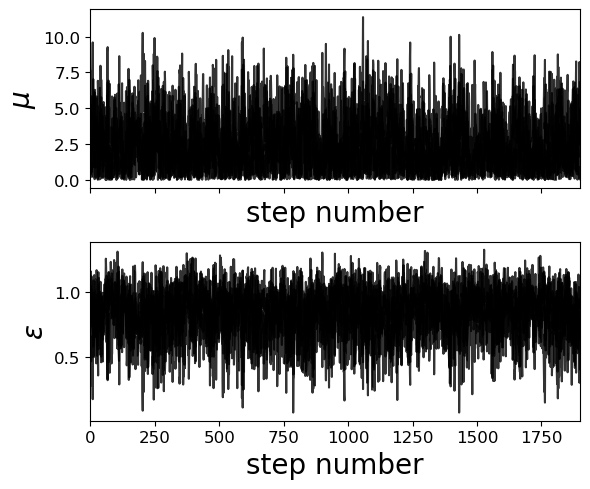

In [142]:
fig, axes = plt.subplots(n_params, sharex=True)

samples = sampler.get_chain(discard=500, thin=5)
labels = [r"$\mu$",r"$\epsilon$"]

for i in range(n_params):

    ax = axes[i]
    ax.plot(samples[:,:,i],"k", alpha=0.8)
    ax.set_xlim(0, len(samples))
    ax.set_xlabel('step number')
    ax.set_ylabel(labels[i])

    
axes[-1].set_xlabel("step number")

# Ajustar los márgenes automáticamente
plt.tight_layout()
#plt.savefig('MCMC_1Channel.pdf')

In [143]:
flat_samples = sampler.get_chain(discard=500, thin=5, flat=True)
truths = np.percentile(flat_samples, 50, axis=0)

In [144]:
#truths = truths[::-1]
truths

array([2.1209528 , 0.86437383])

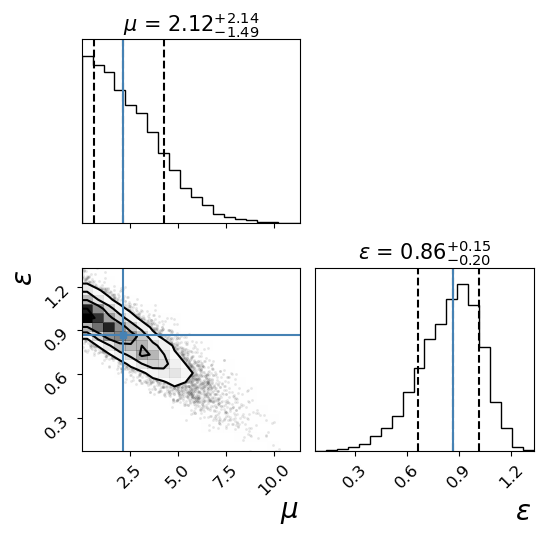

In [145]:
figure = corner.corner(flat_samples, 
                       truths = truths,
                       labels=labels, 
                       quantiles=[0.16,0.5,0.84], 
                       show_titles=True,
                       title_kwargs={"fontsize":15})

axes = figure.axes

for ax in axes:
    ax.xaxis.set_label_coords(0.95,-0.25)
    ax.yaxis.set_label_coords(-0.2,0.95)

# Ajustar los márgenes automáticamente
plt.tight_layout()
plt.savefig('SamplingPosteriorSystematic.pdf')

In [146]:
# Upper limits using the marginal posterior distribution
truths = np.percentile(flat_samples, 95, axis=0)
truths

array([5.80643084, 1.10363292])

In [147]:
matriz_correlacion = np.corrcoef(flat_samples, rowvar=False)
matriz_correlacion

array([[ 1.        , -0.84426391],
       [-0.84426391,  1.        ]])